In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import cv2, os, math, time
from datetime import timedelta
from sklearn.utils import shuffle
from numpy.lib.stride_tricks import as_strided

In [2]:
###Configuration
"""
Data Configurations/Paths
"""
img_dir="../../original_images/SD"
base_model = 'SD/sd_01_.ckpt'
model_20000 = 'SD/sd_20000.ckpt'
model_30000 = 'SD/sd_30000.ckpt'
model_40000 = 'SD/sd_40000.ckpt'
model_50000 = 'SD/sd_50000.ckpt'

connected_model = 'SD/sd_conected.ckpt'

##
# Convolutional Layer 1.
filter_size1 = 4          # Convolution filters are 4 x 4 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 2          # Convolution filters are 2 x 2 pixels.
num_filters2 = 32         # There are 32 of these filters.

# Convolutional Layer 3.
filter_size3 = 2          # Convolution filters are 2 x 2 pixels.
num_filters3 = 64         # There are 64 of these filters.

# Convolutional Layer 4.
filter_size4 = 2          # Convolution filters are 2 x 2 pixels.
num_filters4 = 128         # There are 128 of these filters.

# Fully-connected layer.
fc_size = 2000             # Number of neurons in fully-connected layer.

# We know that images are 60 pixels in each dimension.
# img_size = 8 * 4

# Images are stored in one-dimensional arrays of this length.
img_size_flat = 10 * 10

# Number of colour channels for the images: 3 channel for RGB.
num_channels = 3

# Tuple with height and width of images used to reshape arrays.
img_shape = (10, 10, num_channels)


# Number of classes, one class for same or different image
num_classes = 10*10
patch_size = (2, 2)



In [3]:
def load_data(img_dir):
        list_of_imgs = []
        list_of_labels = []
        list_same_diff = []
        list_img_keys = []
        for img in os.listdir(img_dir):
            
            img_path = os.path.join(img_dir, img)
            list_same_diff.append(int(os.listdir(img_path)[0]))
            list_img_keys.append(img)
            img_path = img_path + "/" + os.listdir(img_path)[0]
            for img_label in os.listdir(img_path):
                img_data = os.path.join(img_path, img_label)
                if img_label == "img":
#                     print(img_data + "/img.png")
                    list_of_imgs.append(img_data + "/img.png")
                else:
                    list_of_labels.append([os.path.join(img_data, label) for label in os.listdir(img_data)])

        data_imgs = np.array(list_of_imgs)
        data_labels = np.array(list_of_labels)
        data_same_diff = np.array(list_same_diff)
        data_img_keys = np.array(list_img_keys)

        return data_imgs, data_labels, data_same_diff, data_img_keys

    
def get_batch_images(data, label, same_diff, img_keys, rshp):
        list_of_imgs = []
        list_of_labels = []
        list_of_same_diff = []
        list_of_img_keys = []
        for img, lbl, img_type, img_key in zip(data, label, same_diff, img_keys):
            orig_img = cv2.imread(img)
            #only first image as a label
            orig_lbl = cv2.imread(lbl[0])
            if orig_img is None or orig_lbl is None:
                    print ("Unable to read image{} or {}".format(img, lbl))
                    continue
            
            flattened_img = orig_img.flatten()
            flattened_lbl = orig_lbl.flatten()

            list_of_imgs.append(np.asarray(flattened_img, dtype=np.float32))
            list_of_labels.append(np.asarray(flattened_lbl, dtype=np.float32))
            list_of_same_diff.append(img_type)
            list_of_img_keys.append(img_key)

        data_labels = np.array(list_of_labels)
        reshaped_labels = np.reshape(data_labels, rshp)
        data_labels = np.squeeze(reshaped_labels[:, :, :1])
#         print(data_labels.shape)
        data_imgs = np.array(list_of_imgs)
        data_img_type = np.array(list_of_same_diff)
        data_img_keys = np.array(list_of_img_keys)
        
        return data_imgs, data_labels, data_img_type, data_img_keys

def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [4]:
def restore_see_layer(ix, model_name=None, var_name=None):
    with tf.Session('', tf.Graph()) as s:
        with s.graph.as_default():
            if ((model_name != None) and var_name != None):
                saver = tf.train.import_meta_graph(model_name+".meta")
                saver.restore(s, model_name)
                fd = {'x:0':ix}
                var_name=var_name+":0"
                    
                result = 0
                result = s.run(var_name, feed_dict=fd)
    return result

def see_output(iNp,depth_filter_to_see=0,cmap="gray",figsize=(4,4)):
    img_x = iNp[0,:,:,:]
    fig = plt.figure(figsize=figsize)
    plt.imshow(img_x, interpolation='none', aspect='auto')
#     plt.colorbar(img_x, orientation='horizontal')
    plt.show()
    
def get_patch_corner(img):
    r = img_shape[0]
    c = img_shape[1]
    rp = patch_size[0]
    cp = patch_size[1]
    conv_r= r - rp + 1
    conv_c = c - cp + 1

    all_ones = np.ones((conv_r,conv_c))
    for i in range(0, rp):
        for j in range(0, cp):
    #         print(np_m[0+i:conv_r+i, 0+j:conv_c+j])
            all_ones = np.multiply(all_ones, img[0+i:conv_r+i, 0+j:conv_c+j])

    return(all_ones)

def normalise(tensor):
    return tf.div(
   tf.subtract(
      tensor, 
      tf.reduce_min(tensor)
   ), 
   tf.subtract(
      tf.reduce_max(tensor), 
      tf.reduce_min(tensor)
   )
)

def normalized(arr):
    return (arr - np.min(arr))/(np.max(arr) - np.min(arr))

def save_patch_images(img_x1, lbl_x1, index):
    if not os.path.exists('./SD/patched_images/' + str(index)):
        os.makedirs('./SD/patched_images/' + str(index))
        os.makedirs('./SD/patched_images/' + str(index) + "/" + str(lbl_x1))
        

    plt.imsave('./SD/patched_images/' + str(index) + "/" + str(lbl_x1) + '/img.png', np.squeeze(img_x1))
    
def extract_combine_patches(train, labels, img_type_lbl, img_key, start_idx):
    patched_images = []
    
    for index in range(0, len(train)):
#         print(index)
        img_x = train[index:index+1, :]
        lbl_x = labels[index:index+1, :]
        img_type_x = img_type_lbl[index]
        img_key_x = img_key[index]
        output_cl1 = restore_see_layer(ix=img_x,model_name=model_50000,var_name='fc_3/fc4')
        output_fc4_w = restore_see_layer(ix=img_x,model_name=model_50000,var_name='fc_3/fc4_W')
        normalized_output = np.rint(normalized(output_cl1))
        np_m = np.squeeze(np.reshape(normalized_output, (1,10,10,1)))
        cornered_image = get_patch_corner(np_m)

        reshaped_img = np.reshape(img_x, (1, 10,10, 3))
        x, y = np.where(cornered_image == 1)
        
        if len(np.where(cornered_image == 1)[0]) > 0:
            tmp_patch = reshaped_img[:, x[0]:x[0] + patch_size[0], y[0]:y[0]+patch_size[1], :]
        else:
            continue
            
        for idx in range(1, len(np.where(cornered_image == 1)[0])):
#             print("index:", idx)
#             print("X:", x)
#             print("Y:", y)
#             print("reshaped image:", reshaped_img)
            tmp_patch1 = reshaped_img[:, x[idx]:x[idx] + patch_size[0], y[idx]:y[idx]+patch_size[1], :]
            tmp_patch = np.expand_dims(np.concatenate((np.squeeze(tmp_patch), np.squeeze(tmp_patch1)), axis=0), axis=0)
        
#         print(tmp_patch.shape)
#         save_patch_images(tmp_patch, img_type_x, start_idx + index)
        save_patch_images(tmp_patch, img_type_x, img_key_x)

        patched_images.append(tmp_patch)
        tmp_patch = []
        
    return patched_images

In [ ]:
train_data, train_labels, img_type, img_keys = load_data(img_dir)
batch_s = 64
total_iterations = 0
start_ = 0
end_ = batch_s
np.set_printoptions(suppress=True)

if not os.path.exists('./SD/patched_images'):
    os.makedirs('./SD/patched_images')

while True:

    train = train_data[start_:end_]
    labels = train_labels[start_:end_]
    img_type_lbl = img_type[start_:end_]
    img_key = img_keys[start_:end_]
    dims = (batch_s, num_classes, num_channels)
    train, labels, img_type_lbl, img_key = get_batch_images(train, labels, img_type_lbl, img_key, dims)
    patch_images = extract_combine_patches(train, labels, img_type_lbl, img_key, start_)
    
    #do my stuff
    if len(train_data) < start_ + batch_s:
        print("{} Images have been processed.".format(total_iterations))
        break
    
    total_iterations +=batch_s
    start_ = end_
    end_ = end_ + batch_s

INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt


In [7]:
train_data, train_labels, img_type, img_keys = load_data(img_dir)

In [30]:
orig_img = cv2.imread("../../original_images/SD/1984/0/img/img.png")
orig_lbl = cv2.imread("../../original_images/SD/1984/0/labels/1_0.png")

flattened_img = orig_img.flatten()
flattened_lbl = orig_lbl.flatten()

In [26]:
orig_lbl

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [255, 255, 255],
        [255, 255, 255],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [255, 255, 255],
        [255, 255, 255],
        [  0,   0, 

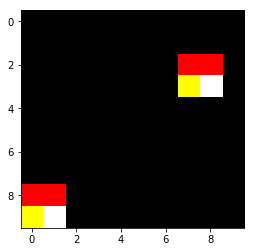

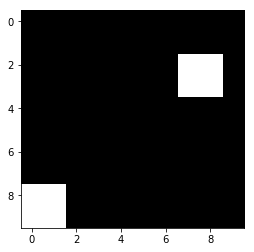

In [28]:
see_output(np.expand_dims(orig_img, axis=0))
see_output(np.expand_dims(orig_lbl, axis=0))

In [50]:
np.set_printoptions(suppress=True)
flat_img = np.expand_dims(flattened_img, axis=0)
output_cl1 = restore_see_layer(ix=flat_img,model_name=model_50000,var_name='fc_3/fc4')
output_fc4_w = restore_see_layer(ix=flat_img,model_name=model_50000,var_name='fc_3/fc4_W')

normalized_output = np.rint(normalized(output_cl1))
np_m = np.squeeze(np.reshape(normalized_output, (1,10,10,1)))
# np_m.shape
cornered_image = get_patch_corner(np_m)
# print(np.reshape(output_cl1, (1, 10, 10, 1)))
print(normalized(output_cl1))
print(normalized_output)
print(np_m)
print(cornered_image)
# reshaped_img = np.reshape(flat_img, (1, 10,10, 3))

# x, y = np.where(cornered_image == 1)
# tmp_patch = reshaped_img[:, x[0]:x[0] + patch_size[0], y[0]:y[0]+patch_size[1], :]
# tmp_patch1 = reshaped_img[:, x[1]:x[1] + patch_size[0], y[1]:y[1]+patch_size[1], :]
# tmp_patch = np.expand_dims(np.concatenate((np.squeeze(tmp_patch), np.squeeze(tmp_patch1)), axis=0), axis=0)

# see_output(tmp_patch)

INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
[[0.23859362 0.33167922 0.19057521 0.07842246 0.17050785 0.12396035
  0.12734902 0.35867307 0.23339188 0.06867442 0.09293447 0.19598952
  0.2552593  0.0960983  0.15249455 0.2201699  0.16864784 0.2901475
  0.20421249 0.07241403 0.         0.06209196 0.28156415 0.1664155
  0.10977262 0.15784009 0.07519916 0.49581978 0.8143641  0.3413308
  0.15050352 0.24916588 0.24496588 0.08936904 0.13764682 0.2236701
  0.08162319 0.72380257 0.9998216  0.32280725 0.15448181 0.08194567
  0.05349547 0.10862757 0.12776549 0.25663322 0.19770534 0.25768137
  0.19789383 0.03149737 0.12527342 0.11237378 0.11549314 0.0652553
  0.07312917 0.09027658 0.08974443 0.15612724 0.03766199 0.02101506
  0.01007344 0.16601166 0.33066028 0.04499621 0.04636591 0.10928779
  0.06937906 0.26291928 0.28632626 0.16532661 0.19136916 0.14856371
  0.23873897 0.12752318 0.15019177 0.23660778 0.13595521 0.13739116
  0